(sec:exercise-ogura)=
# 演習2 - 百人一首エージェントの作成

In [ ]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

try:
    from myst_nb import glue
except ImportError:
    glue = lambda *args, **kwargs: None

rc = {"figure.dpi": 150}
sns.set_theme(style="white", rc=rc)
japanize_matplotlib.japanize()

今回の演習では、小倉百人一首をプレイヤーAIを作成してみよう。ご存じの通り、小倉百人一首は、100種類の短歌からなる**かるた**の一種であり、**読み札**は短歌の上の句 (5・7・5の部分)であり、**取り札**が下の句(7・7の部分)である。

通常の小倉百人一種では、読み札には上の句と下の句の両方が漢字で書かれており、さらに挿絵がある。一方で取り札は下の句が濁点や半濁点を含まないひらがな48種類(「ゐ」と「ゑ」を含む)によって書かれている。

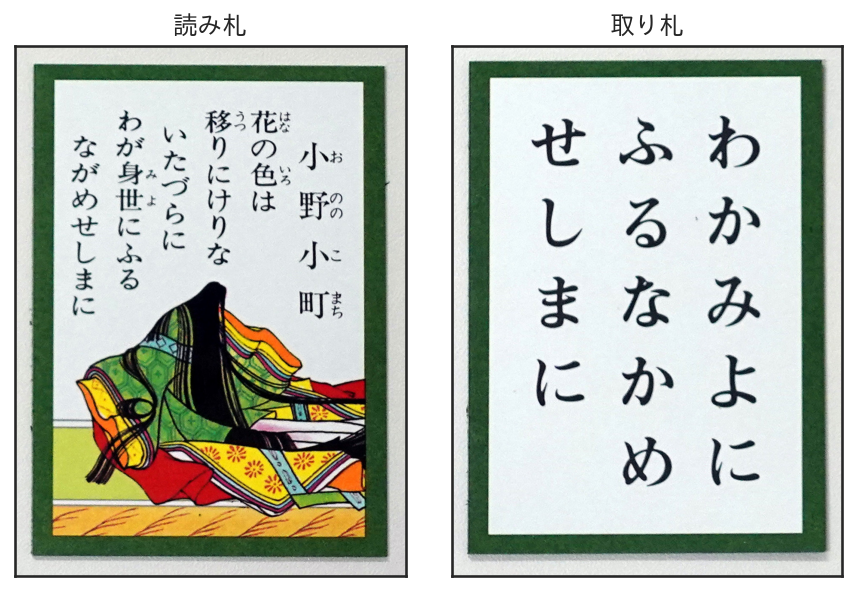

In [ ]:
yomi = cv2.imread("../../data/ogura/yomifuda.jpg", cv2.IMREAD_COLOR)
tori = cv2.imread("../../data/ogura/torifuda.jpg", cv2.IMREAD_COLOR)

fig = plt.figure()
gs = fig.add_gridspec(1, 2)

ax = plt.subplot(gs[0])
ax.imshow(yomi[:, :, ::-1])
ax.set(xticks=[], yticks=[], title="読み札")

ax = plt.subplot(gs[1])
ax.imshow(tori[:, :, ::-1])
ax.set(xticks=[], yticks=[], title="取り札")

fig.tight_layout()
glue("fuda-images", fig)

plt.close()

:::{glue:figure} fuda-images
:figwidth: 80%
:::

百人一首には、「チラシ」や「源平」などのいくつかのルールがあるが、一般的な個人競技の場合は100枚の札のうち50枚だけを並べて、それを2人のプレイヤーによって取り合う。

取り札は、2人の競技者のそれぞれが自分の陣地に25枚ずつを配置する。読み札は100枚全てを用いるので、「空札」といって、読まれたけれども50枚の取り札には含まれない札というのも存在する。

百人一首には**決り字**という考え方がある。決り字とは、読み札が何文字読まれたら取り札を取る事ができるのかを表す文字数である。

例えば、上図に示した「はなのいろは...」という句は、「はな」から始まる句として「はなさそふ...」が存在するため「はな」の時点では取り札を取ることができない。しかし「はなの」から始まる句は他に存在しないので、決り字は「3」となる。

細かな百人一首のルールについては、以下の全日本かるた協会のウェブサイトを参考にしてほしい。

**はじめての競技かるた:** <https://www.karuta.or.jp/karuta/first-time/>

## 演習内容

今回の演習では、取り札が複数含まれた画像と、上の句の文字列が複数与えられる。

**入力画像:**

```{image} ../../data/ogura/level2.jpg
:align: left
:width: 60%
:class: float-none mb-3
```

**入力文字列:**

```
はなのいろはうつりにけりないたつらに
あきのたのかりほのいほのとまをあらみ
あさほらけうちのかはきりたえたえに
```

このような入力に対し、各読み札に対応する取り札が「何文字読まれた時点で取れるのか」を表す数字を返すプログラムを作成する。また、対応する取り札が存在しない場合には0を返す。

上記の例に対する正解は以下のようになる。

**正解出力:**

```
1
0
6
```

上の入力例で、「はなのいろは...」で始まる句は決り字が3文字の「はなの」であるが、画像に写っている3枚の取り札のうち、他に上の句が「は」で始まる句は存在しないため、この例では「は」が読まれた時点で「はなのいろは...」に対応する取り札である「わかみよにふる...」を取ることができる。従って、期待される出力は1である。

次に「あきのたの...」で始まる句だが、これは下の句が「わかころもてに...」である。しかし、この下の句に対応する取り札は画像中に存在しないため、期待される出力は0である。

最後の「あさほらけうちの...」で始まる句の下の句は「あらわれわたる...」であるが、「あさほらけ...」で始まる上の句は「あさほらけうちの...」の他に「あさほらけありあけの...」があり、その下の句は「よしののさとに...」である。今回の画像には「あらわれわたる...」と「よしののさとに...」の両方の取り札が存在しているので、「あさほらけうちの...」の6文字目まで読まれなければ「あらわれわたる...」の取り札を取ることはできない。従って、期待される出力は6である。

これらを踏まえて、以下のような**画像 (image)** と **文字列の配列 (poems)** および**問題のレベル (level)**を引数として、各和歌の決まりの状況を示す配列 (各要素は0-2)を返す以下の関数を実装すること。

```python
def solve(image: npt.NDArray[np.uint8], poems: list[str], level: int) -> list[int]:
    """
    Inputs:
      image: input color image with size (H, W, 3)
      poems: list of Ogura poems
      level: difficulty of the problem (from 1 to 3)
    Outputs:
      answer: list of integers, where each integer represent the number
      with which the player can uniquely determine the corresponding poem.
      If the poem is inexistent, the integer is expected to be 0.
    """
    answer = [0] * len(poems)
    return answer
```

### 問題のレベル

今回の演習では、以下の3つのレベルの入力を用意している。なお全レベルにおいて、与えられる読み札の文字列の数は3-5であり、取り札同士が重なっていることはない。

- **レベル1:** 画像に写っている取り札は1枚だけである。また、取り札は必ず画像に正しい向きで写っている。
- **レベル2:** 画像に写っている取り札は3枚以上、5枚以下である。しかし、取り札の向きは任意である。
- **レベル3:** 画像に写っている取り札は不特定多数であり、取り札の向きも任意である。

これら、各レベルの入力が10枚ずつ与えられ、レベルに対応する点数、すなわちレベル1なら1点、レベル2なら2点、レベル3なら3点が、出力が完璧に正しい場合にのみ与えられる(したがって部分点はない)。以下に、実際に与えられる画像の例を示す。

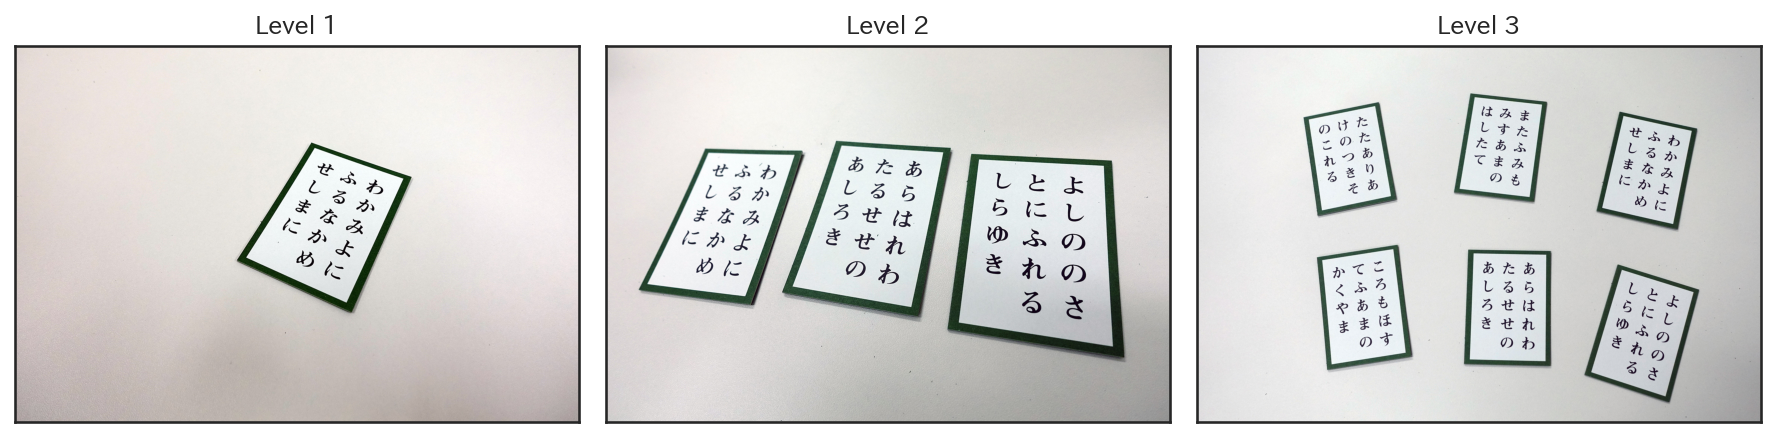

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

level1 = cv2.imread("../../data/ogura/level1.jpg")[:, :, ::-1]
level2 = cv2.imread("../../data/ogura/level2.jpg")[:, :, ::-1]
level3 = cv2.imread("../../data/ogura/level3.jpg")[:, :, ::-1]

fig = plt.figure(figsize=(12, 4))

a1 = level1.shape[1] / level1.shape[0]
a2 = level2.shape[1] / level2.shape[0]
a3 = level3.shape[1] / level3.shape[0]

# create subplots
gs = gridspec.GridSpec(1, 3, width_ratios=[a1, a2, a3])
p1 = plt.subplot(gs[0])
p2 = plt.subplot(gs[1])
p3 = plt.subplot(gs[2])

p1.imshow(level1)
p1.set(title="Level 1", xticks=[], yticks=[])

p2.imshow(level2)
p2.set(title="Level 2", xticks=[], yticks=[])

p3.imshow(level3)
p3.set(title="Level 3", xticks=[], yticks=[])

plt.tight_layout()
plt.show()

### ローカル環境でのテスト

本番の採点は[GitHub Classroom](https://classroom.github.com/classrooms)を使って行う。講義中で課題用のClassroomのURLを指示するので、そのURLをブラウザで開き、テンプレート・レポジトリを自分のGitHubアカウントと紐付けること。

その後、レポジトリをcloneして、ローカル環境で`ogura.py`を編集してテストを実施する。まずは、各レベル5問ずつ練習データを提供するので、それを用いてテストを行うと良い。以下のURLからZIPファイルをダウンロードして、講義中に伝えるパスワードで展開して使うこと。

**サンプルファイル (各レベル5枚の計15枚)**
- <https://github.com/tatsy-classes/ogura-agent-template/raw/master/data/samples.zip>

また、百人一首の一覧を5,7,5,7,7の節ごとに区切ったリストを以下のURLにCSVファイルとして用意しているので、こちらも利用して良い。

**百人一首の一覧**
- <https://github.com/tatsy-classes/ogura-agent-template/raw/master/data/ogura.csv>

### 本番環境でのテスト

以後、課題用のレポジトリにコードをpushする度にテストが走る。

本番環境では、一問(＝画像1枚)ごとに**最大実行時間を15秒**に設定している。実行にそれ以上の時間がかかった場合、自動的にプログラムが終了し、エラーメッセージ等も表示されないので注意すること。

本講義では、実際の問題として与えている画像を公開することはしないが、どの程度の画像に対してプログラムが正しく動いているかは、Github Actionsのログを見ることで確認できる。

より詳細な課題作成の流れについてはテンプレート・レポジトリの[README.md](https://github.com/tatsy-classes/ogura-agent-template)を確認すること。

:::{admonition} 使用可能なライブラリ
:class: warning

今回の実行環境では、以下のURLにある`requirements.txt`を用いて使用可能なモジュールをインストールする (Pipを使ってインストールされる)。従って、これ以外のライブラリは使用できないので注意すること。

- [requirements.txt](https://github.com/tatsy-classes/ogura-template/blob/master/requirements.txt)

本番のテスト環境においては、深層学習等にもCPUを用いるが、学習はGoogle Colab上などでGPUを用いて行っても良い。その場合、デバイスが学習環境と実行環境で異なるため、重みパラメータの読み込みコードに注意すること (PyTorchであれば `torch.load`の引数に`map_location=...`を指定する)。

また、本講義ではPyTorchの使用方法について解説したが、TensorFlowやKerasの方が使い方に慣れている場合は、そちらを用いても良い。ただ、その場合も**テスト環境ではCPUしか使うことができない**ことに注意すること。

また、仮にPyTorch以外のライブラリを用いた場合に生じる問題については質問は受け付けないので、各自で解決すること。
:::

## プログラム作成のヒント

### 取り札の取り出しについて

[図形の検出](ssec:figure-from-photo)の節で説明した方法を用いて取り札に対応する四角形を取り出し、パースを除去することによって、取り札の画像が取得できる。

ただし、今回の演習では、数独の演習と異なり画像中に複数の取り札が含まれため`findContours`で取得した境界線について、それが取り札の輪郭なのか否かを判断する必要がある。

また、取り札の境界は緑色の和紙で縁取りされていて、**エッジ検出を単純に適用すると二重で輪郭線が取られてしまう**ので、その点にも注意が必要だろう。

ただし、入力画像には**取り札以外の余計なものは写っていない**ことが保証されているので、それを利用すれば取り札の検出はそれほど難しくはないだろう。

### 決り字について

本演習で扱う「決り字」は、百人一首において一般的に言われる決り字とは意味合いが異なるので注意すること。

一般的な決り字は「取り札として100種類の句がある場合に、上の句が何文字読まれたら、各取り札を取って良いのか」を表しているが、本演習では、取り札の数が限られているので、この場合には「一般的な決り字」より少ない文字数が読まれた段階で取り札を決定できる。

従って、この「実際の決り字」は、画像から取り札を全て検出した上で計算する必要がある。

### ひらがなの認識について

今回の演習においては、**札の向きは任意である**ため、ひらがながどのような向きであっても認識できるように分類器を用意するか、あるいは、正しい向きに取り札の画像を回転する処理のいずれかが必要になる。

ただ、取り札の上でひらがなが書かれている位置は、全ての札で共通なので、各文字が書かれている位置を判別する際には、その前提知識を用いると良い。

また、学習データセットの作成については、[数独の演習](sec:exercise-sudoku)で紹介したPillowの`ImageDraw`を用いる方法を用いれば良い。